<a href="https://colab.research.google.com/github/eduardocarbo/Biography/blob/main/comparaci_n_de_calibracion_de_clasificadores_con_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Los clasificadores bien calibrados son clasificadores probabilísticos para los cuales las salida de predict_proba se puede interpretar directamente como un nivel de confianza. Por ejemplo, un clasificador bien calibrado (binario) debería clasificar las muestras de manera que, en el caso de las muestras a las que les dio un valor de predrict_proba cercano a 0,8, aproximadamente el 80% pertenezca en realidad a la clase positiva.

En este ejemplo compararemos la claibración de cuatro modelos diferentes: regresión logística, gaussian naive bayes, clasificador de bosque aleatorio y SVM lineal.


#Conjunto de datos

Utilizaremos un conjunto de datos de clasficación binaria sintética con 100.000 muestras y 20 características. De las 20 características, solo 2 son informativas, 2 son redundantes (combinacioners aleatorias de las características informativas) y las 16 restantes no son informativas (números aleatorios).

De las 199.9999 muerstras, 100 se utilizarán para el ajuste del modelo y las restantes para la prueba. Cabe señalar que esta división es bastante inusual: el objetivo es obtener estimaciones de curvas de calibración estables para modelos que son potencialmente propensos al sobreajuste. En la práctica, se debería utilizar una validación cruzada con divisiones más equilibradas, pero esto haría que el código de este ejemplo fuera más complicado de seguir.




In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

#Curvas de calibración
A contunación, entrenamos cada uno de los cuatro modelos con el pequeño conjunto de datos de entrenamiento y luego trazamos curvas de calibración (también conocidas como diagramas de cinfiabilidad) utlizando las probabilidades predichas del conjunto de datos de prueba. Las curvas de calibración se crean agrupando las probabilidades predichas y leugo graficando la probabilidad predicha media en cada grupo contra la frecuencia observada ("fracción de positivos"). Debajo de la curva de calibración, trazamos un histograma que muestra la distribución de las probabilidades predichas o, más especificamente, la cnatidad de muestras en cada grupo de probabilidad predicha.

In [ ]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [ ]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# Define the classifiers to be compared in the study.
#
# Note that we use a variant of the logistic regression model that can
# automatically tune its regularization parameter.
#
# For a fair comparison, we should run a hyper-parameter search for all the
# classifiers but we don't do it here for the sake of keeping the example code
# concise and fast to execute.
lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

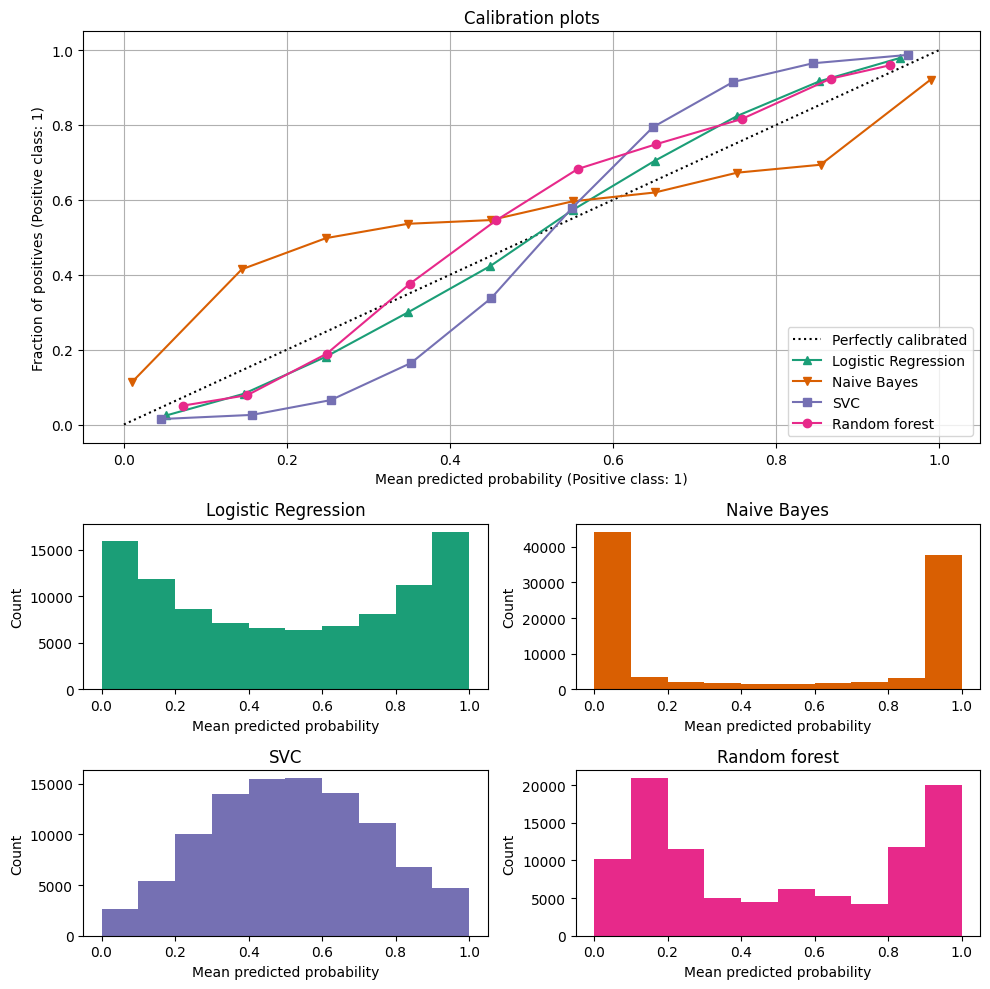

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()